In [1]:
# load general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

## Uncomment for nicer plots ##
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

Load the data

In [2]:
df = pd.read_excel(r'vars.xlsx')
start = 0
stop = 1414
a = np.linspace(-0.3,1000,1414)

g = (df.g1[start:stop] + df.g1[start:stop]) / 2

In [10]:
a[-1]

1000.0

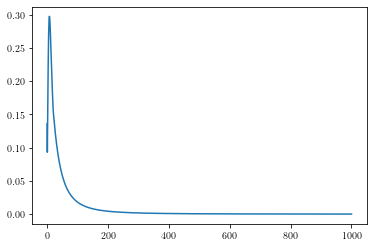

In [3]:
plt.plot(a,g)

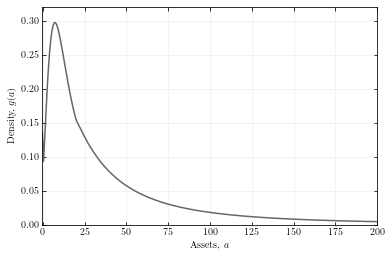

In [49]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.plot(a, g, color = '0.4', zorder = 2, label = r'$g(a)$')
# ax.set(xscale='log', yscale = 'log')

ax.set_xlim(-0.3,200)
ax.set_ylim(0,0.32)

ax.set_xlabel(r'Assets, $a$')
ax.set_ylabel(r'Density, $g(a)$')

# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/model.pdf')

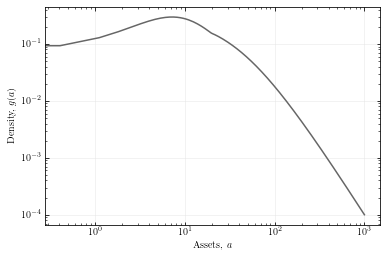

In [48]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.plot(a, g, color = '0.4', zorder = 2, label = r'$g(a)$')
ax.set(xscale='log', yscale = 'log')

# ax.set_xlim(-0.3,200)
# ax.set_ylim(0,0.32)

ax.set_xlabel(r'Assets, $a$')
ax.set_ylabel(r'Density, $g(a)$')

# ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/model_log.pdf')

# Simulations

Draw from the asset distribution using rejection sampling

In [4]:
def den_pareto2(x, alpha, mu):
    
    '''Return the density of the Pareto type II distribution'''
    
    den = alpha*(1 + x - mu)**(- (alpha + 1))
    
    return den

In [5]:
density_pareto = den_pareto2(a, 1.0, np.min(a))
c = g/density_pareto

Check for the maxima of $c$

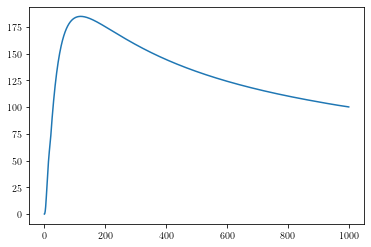

In [6]:
plt.plot(a,c)

In [8]:
c_max = np.max(c) + 5

189.89686817182962

Seems to be around 190

Generate function for empirical density based on g

In [9]:
f = interpolate.interp1d(a,g, bounds_error = False, fill_value = 0)
h = interpolate.interp1d(a,density_pareto, bounds_error = False, fill_value = 0)

In [10]:
h(2000)

array(0.)

Run the rejection sampling algorithm

In [11]:
N = 5000
temp = np.empty(shape=N)

for i in range(N):
    
    rand = np.random.uniform(0,1)
    temp[i] = mu + (1 - rand)**(-1/alpha) - 1
    

NameError: name 'mu' is not defined

In [60]:
np.max(temp)

3603.44123619249

In [16]:
N = 1000
rejection_sample = np.empty(shape=N)
mu = -0.3
alpha = 1.5

i = 0
while i < N:
    
    # Draw uniform number
    u = np.random.uniform(0,1)
    
    # Draw from Pareto type II
    rand = np.random.uniform(0,1)
    x = mu + (1 - rand)**(-1/alpha) - 1

    if f(x) == 0.0:
        rejection_sample[i] = x
        i += 1

    else:        
        if u <= f(x) / (c_max*h(x)):
            rejection_sample[i] = x
            i += 1

        else:
            i = i    


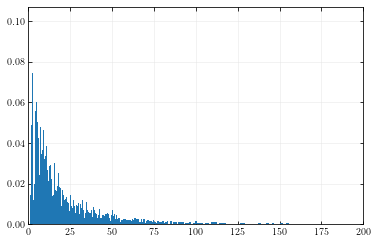

In [13]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(rejection_sample, bins = np.logspace(0,5, 1000), density = True)
# ax.plot(a,g)

ax.set_xlim(0,200)

plt.show()

In [14]:
np.max(rejection_sample)

2307.353961993013

In [ ]:
np.subtract.outer()

In [17]:
# Compute gini
def gini_coefficient(x):

    """Compute the Gini coefficient for array of values"""
    
    diffsum = 0
    for i,xi in enumerate(x[:-1],1):
        diffsum += np.sum(np.abs(xi - xi[i:]))
        
    return diffsum / (len(x)*2*np.mean(x))

def gini(x):
    
    '''Compute Gini coefficient'''
    
    mad = np.abs(np.subtract.outer(x,x)).mean()
    rmad = mad/np.mean(x)
    g = 0.5 * rmad
    
    return g

Monte Carlo experiment for the Gini coefficient

In [20]:
G = gini(rejection_sample)
G

0.7069629598427151

In [22]:
# Parameters
N = 1000
reps = 10000
mu = -0.3
alpha = 1.5

# Initialize
gini_array = np.empty(shape=reps)

# Loop over reps
for j in range(reps):
    
    ####################################
    ## Sample from model distribution ##
    ####################################

    # Initialize
    rejection_sample = np.empty(shape=N)
    i = 0

    # Use rejection sampling
    while i < N:

        # Draw uniform number
        u = np.random.uniform(0,1)

        # Draw from Pareto type II
        rand = np.random.uniform(0,1)
        x = mu + (1 - rand)**(-1/alpha) - 1

        if f(x) == 0:
            rejection_sample[i] = x
            i += 1
            
        else:        
            if u <= f(x) / (c_max*h(x)):
                rejection_sample[i] = x
                i += 1

            else:
                i = i
            
    ##############################
    ## Compute Gini coefficient ##
    ##############################
    gini_array[j] = gini(rejection_sample)
#     print(j)

KeyboardInterrupt: 

In [24]:
np.max(gini_array)

0.9795577492739735

In [32]:
gini_values = gini_array[gini_array>0.1]
np.shape(gini_values)

(8694,)

In [63]:
np.mean(gini_values)

0.6661602097399003

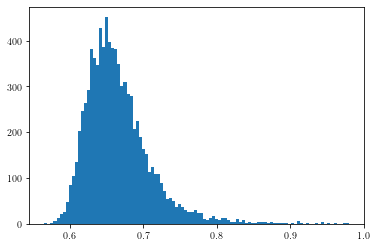

In [35]:
plt.hist(gini_values, bins = 100)
plt.show()

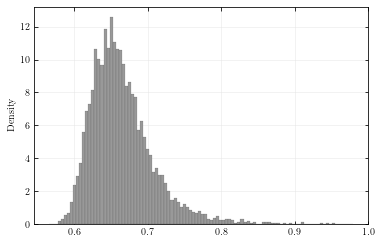

In [62]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(gini_values, bins = 100, density = True, color = '0.6', edgecolor = 'k', linewidth = 0.1)

ax.set_ylabel('Density')

plt.savefig('../../tex/figs/gini_distribution.pdf')